# 3.5 — Semantic Equivalence Between Original and Obfuscated XSS  
### Playwright headless + multi-oracle + per-technique statistics (Reproduction + Improvements)

**Multi-oracle** (cải tiến so với chỉ `alert()`):
- Dialogs (`alert/confirm/prompt`): số lượng + message
- DOM snapshot hash: so sánh thay đổi DOM
- Console + page errors: lỗi runtime/exception
- Network attempts: chặn toàn bộ request nhưng vẫn log để phát hiện nỗ lực exfil/load
- Navigation attempts: log thay đổi URL

> Notebook này chạy payload **trong trang HTML local** và **chặn network** để phục vụ đánh giá/đo lường.


In [3]:
# If Playwright is missing, this cell will install it.
# If Playwright browsers are missing, it will also install Chromium once.

import asyncio, hashlib, re
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys, subprocess

try:
    from playwright.async_api import async_playwright, TimeoutError as PWTimeout
except ModuleNotFoundError:
    %pip install playwright
    from playwright.async_api import async_playwright, TimeoutError as PWTimeout

# Ensure Chromium browser is available for Playwright (safe to re-run; it will skip if already installed)
subprocess.run([sys.executable, "-m", "playwright", "install", "chromium"], check=False)


   ---------------------------------------- 0.0/36.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/36.6 MB ? eta -:--:--
   - -------------------------------------- 1.0/36.6 MB 6.4 MB/s eta 0:00:06
   ----- ---------------------------------- 5.2/36.6 MB 14.9 MB/s eta 0:00:03
   ------------ --------------------------- 11.8/36.6 MB 21.3 MB/s eta 0:00:02
   ---------------- ----------------------- 14.9/36.6 MB 19.8 MB/s eta 0:00:02
   ------------------------ --------------- 22.8/36.6 MB 23.8 MB/s eta 0:00:01
   ----------------------------- ---------- 27.3/36.6 MB 25.5 MB/s eta 0:00:01
   ---------------------------------- ----- 31.5/36.6 MB 24.4 MB/s eta 0:00:01
   ---------------------------------------  35.7/36.6 MB 23.5 MB/s eta 0:00:01
   ---------------------------------------- 36.6/36.6 MB 21.6 MB/s  0:00:01

   -------------------- ------------------- 1/2 [playwright]
   -------------------- ------------------- 1/2 [playwright]
   -------------------- --------

CompletedProcess(args=['c:\\Users\\ADMIN\\AppData\\Local\\Programs\\Python\\Python313\\python.exe', '-m', 'playwright', 'install', 'chromium'], returncode=0)

In [6]:
# ----------------------------
# 1) Load datasets (3.2 / 3.4)
# ----------------------------
DATA_DIR = Path("./report_3_4")

P_32 = "./Dataset/test_obfuscated_safe_multi.csv"

P_34_TOOL = DATA_DIR / "obf_tool_baseline_for_3_4.csv"
P_34_T10  = DATA_DIR / "obf_llm_style_t1_0_for_3_4.csv"
P_34_T15  = DATA_DIR / "obf_llm_style_t1_5_for_3_4.csv"

# print("Found 3.2:", P_32.exists())
# print("Found 3.4 tool/t1.0/t1.5:", P_34_TOOL.exists(), P_34_T10.exists(), P_34_T15.exists())

# if not P_32.exists():
#     raise FileNotFoundError("Missing test_obfuscated_safe_multi.csv (3.2). Place it next to this notebook.")

df32 = pd.read_csv(P_32)

df32_std = df32.rename(columns={
    "payload_original":"payload_original",
    "payload_obfuscated":"payload_obfuscated",
    "technique":"technique",
}).copy()
df32_std["source"] = "3.2_multi"
df32_std["technique"] = df32_std["technique"].astype(str)

dfs = [df32_std[["sample_id","label","payload_original","payload_obfuscated","technique","source"]]]

def load34(path, source_name):
    d = pd.read_csv(path)
    return pd.DataFrame({
        "sample_id": d["sample_id"].astype(int),
        "label": d["label"].astype(int),
        "payload_original": d["payload_original"].astype(str),
        "payload_obfuscated": d["payload_obfuscated"].astype(str),
        "technique": (d["recipe"] if "recipe" in d.columns else source_name).astype(str),
        "source": source_name
    })

if P_34_TOOL.exists(): dfs.append(load34(P_34_TOOL, "3.4_tool"))
if P_34_T10.exists():  dfs.append(load34(P_34_T10,  "3.4_llm_t1.0"))
if P_34_T15.exists():  dfs.append(load34(P_34_T15,  "3.4_llm_t1.5"))

df_all = pd.concat(dfs, ignore_index=True)

# Semantic equivalence is most meaningful on malicious payloads
df_all_mal = df_all[df_all["label"] == 1].reset_index(drop=True)

df_all.shape, df_all_mal.shape


((18416, 6), (8784, 6))

In [7]:
# ----------------------------
# 2) Experiment knobs
# ----------------------------
SEED = 42
np.random.seed(SEED)

RUN_MODES = ["parse", "innerhtml"]   # improvement: two injection contexts
SETTLE_MS = 800
PAGE_TIMEOUT_MS = 8000

MAX_TOTAL = None
MAX_PER_TECHNIQUE = 200   # set None for full

CONCURRENCY = 6

print("RUN_MODES:", RUN_MODES, "| SETTLE_MS:", SETTLE_MS, "| CONCURRENCY:", CONCURRENCY)


RUN_MODES: ['parse', 'innerhtml'] | SETTLE_MS: 800 | CONCURRENCY: 6


In [8]:
# ----------------------------
# 3) Utilities: validity heuristic + HTML template
# ----------------------------
def balanced_simple(s: str) -> int:
    s = s or ""
    pairs = {"(":")","[":"]","{":"}"}
    stack=[]
    for ch in s:
        if ch in pairs:
            stack.append(pairs[ch])
        elif ch in pairs.values():
            if not stack or stack.pop() != ch:
                return 0
    if stack:
        return 0
    if s.count("'") % 2 != 0:
        return 0
    if s.count('"') % 2 != 0:
        return 0
    return 1

def js_template_escape(s: str) -> str:
    # safe-ish embedding into JS template literal
    return (s.replace('\\', '\\\\')
             .replace('`', '\\`')
             .replace('${', '\\${}'))

def make_html(payload: str, mode: str) -> str:
    payload = payload if payload is not None else ""
    if mode == "parse":
        inj = payload
        post = ""
    elif mode == "innerhtml":
        inj = ""
        esc = js_template_escape(payload)
        post = f'''<script>
  try {{
    document.getElementById("inj").innerHTML = `{esc}`;
  }} catch(e) {{
    console.error("INJECT_ERROR", e && e.message ? e.message : e);
  }}
</script>'''
    else:
        raise ValueError("Unknown mode")

    html = f'''<!doctype html>
<html>
<head>
<meta charset="utf-8">
<meta http-equiv="Content-Security-Policy"
      content="default-src 'none'; img-src data:; style-src 'unsafe-inline'; script-src 'unsafe-inline' 'unsafe-eval'; connect-src 'none'; frame-src 'none'; base-uri 'none'; form-action 'none'">
<title>xss-semantic-test</title>
<script>
  window.__netlog = [];
  const log = (k, v) => {{ try {{ window.__netlog.push([k, String(v)]); }} catch(e) {{}} }};

  // Block fetch
  window.fetch = function(...args) {{ log("fetch", args[0]); return Promise.reject(new Error("fetch blocked")); }};

  // Block XHR
  const _XHR = window.XMLHttpRequest;
  function XHR() {{
    const x = new _XHR();
    x.open = new Proxy(x.open, {{ apply(t, thisArg, args) {{ log("xhr", args[1]); throw new Error("xhr blocked"); }} }});
    return x;
  }}
  window.XMLHttpRequest = XHR;

  // Block sendBeacon
  if (navigator.sendBeacon) {{
    navigator.sendBeacon = function(url, data) {{ log("beacon", url); return false; }};
  }}

  // Prevent location changes
  window.location.assign = function(url) {{ log("nav_assign", url); throw new Error("navigation blocked"); }};
  window.location.replace = function(url) {{ log("nav_replace", url); throw new Error("navigation blocked"); }};
</script>
</head>
<body>
<div id="inj">{inj}</div>
{post}
</body>
</html>'''
    return html


In [9]:
# ----------------------------
# 4) Core runner + comparator (multi-oracle)
# ----------------------------
async def run_once(browser, payload: str, mode: str):
    ctx = await browser.new_context(java_script_enabled=True)

    net_attempts = []
    async def route_handler(route, request):
        net_attempts.append(request.url)
        await route.abort()
    await ctx.route("**/*", route_handler)

    page = await ctx.new_page()

    dialogs = []
    console_msgs = []
    page_errors = []
    navigations = []

    page.on("dialog", lambda d: dialogs.append((d.type, d.message)) or asyncio.create_task(d.dismiss()))
    page.on("console", lambda msg: console_msgs.append((msg.type, msg.text)))
    page.on("pageerror", lambda err: page_errors.append(str(err)))
    page.on("framenavigated", lambda frame: navigations.append(frame.url))

    valid_like = balanced_simple(payload)

    html = make_html(payload, mode)
    status = "ok"
    try:
        await page.set_content(html, wait_until="load", timeout=PAGE_TIMEOUT_MS)
        await page.wait_for_timeout(SETTLE_MS)
    except PWTimeout:
        status = "timeout"
    except Exception as e:
        status = f"error:{type(e).__name__}"

    try:
        dom = await page.evaluate("() => document.documentElement.outerHTML")
    except Exception as e:
        dom = f"DOM_ERROR:{type(e).__name__}"

    dom_hash = hashlib.sha256(dom.encode("utf-8", errors="ignore")).hexdigest()

    try:
        netlog = await page.evaluate("() => window.__netlog || []")
    except Exception:
        netlog = []

    await ctx.close()

    return {
        "status": status,
        "mode": mode,
        "valid_like": valid_like,
        "dialogs": dialogs,
        "console": console_msgs,
        "page_errors": page_errors,
        "navigations": navigations,
        "net_attempts": net_attempts,
        "netlog": netlog,
        "dom_hash": dom_hash,
    }

def compare_obs(a: dict, b: dict):
    return {
        "status_a": a["status"], "status_b": b["status"],
        "ok_a": int(a["status"]=="ok"), "ok_b": int(b["status"]=="ok"),
        "dialog_match": int(a["dialogs"] == b["dialogs"]),
        "dialog_count_a": len(a["dialogs"]), "dialog_count_b": len(b["dialogs"]),
        "dom_match": int(a["dom_hash"] == b["dom_hash"]),
        "error_match": int((len(a["page_errors"])==0) == (len(b["page_errors"])==0)),
        "errors_a": len(a["page_errors"]), "errors_b": len(b["page_errors"]),
        "net_attempts_a": len(a["net_attempts"]), "net_attempts_b": len(b["net_attempts"]),
        "netlog_a": len(a["netlog"]), "netlog_b": len(b["netlog"]),
        "semantic_match_strict": int(
            (a["status"]=="ok" and b["status"]=="ok")
            and (a["dialogs"] == b["dialogs"])
            and (a["dom_hash"] == b["dom_hash"])
            and (len(a["page_errors"])==0 and len(b["page_errors"])==0)
        )
    }


In [10]:
# ----------------------------
# 5) Build evaluation queue (optional caps)
# ----------------------------
work = df_all_mal.copy()

if MAX_PER_TECHNIQUE is not None:
    parts=[]
    for (src, tech), g in work.groupby(["source","technique"]):
        take = min(len(g), MAX_PER_TECHNIQUE)
        parts.append(g.sample(n=take, random_state=SEED))
    work = pd.concat(parts, ignore_index=True)

if MAX_TOTAL is not None:
    work = work.sample(n=min(len(work), MAX_TOTAL), random_state=SEED).reset_index(drop=True)

print("Work rows:", len(work))
work.head()


Work rows: 5328


,sample_id,label,payload_original,payload_obfuscated,technique,source
0,1204,1,<style>:target {transform: rotate(180deg);}</s...,PHN0eWxlPjp0YXJnZXQge3RyYW5zZm9ybTogcm90YXRlKD...,base64,3.2_multi
1,2800,1,"<wbr onkeypress=""alert(1)"" contenteditable>tes...",PHdiciBvbmtleXByZXNzPSJhbGVydCgxKSIgY29udGVudG...,base64,3.2_multi
2,1115,1,<code onfocusout=alert(1) tabindex=1 id=x></co...,PGNvZGUgb25mb2N1c291dD1hbGVydCgxKSB0YWJpbmRleD...,base64,3.2_multi
3,1438,1,<datalist onfocusout=alert(1) tabindex=1 id=x>...,PGRhdGFsaXN0IG9uZm9jdXNvdXQ9YWxlcnQoMSkgdGFiaW...,base64,3.2_multi
4,2568,1,<wbr onpointerover=alert(1)>xss</wbr>,PHdiciBvbnBvaW50ZXJvdmVyPWFsZXJ0KDEpPnhzczwvd2...,base64,3.2_multi


In [12]:
# ----------------------------
# 6) Run evaluation (async + concurrency)
# ----------------------------
async def evaluate_dataframe(df: pd.DataFrame):
    results=[]
    sem = asyncio.Semaphore(CONCURRENCY)

    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)

        async def one_row(r):
            async with sem:
                orig = str(r["payload_original"])
                obf  = str(r["payload_obfuscated"])
                row_out = {
                    "sample_id": int(r["sample_id"]),
                    "source": str(r["source"]),
                    "technique": str(r["technique"]),
                }
                mode_flags=[]
                for mode in RUN_MODES:
                    a = await run_once(browser, orig, mode)
                    b = await run_once(browser, obf, mode)
                    cmp = compare_obs(a, b)
                    for k,v in cmp.items():
                        row_out[f"{mode}__{k}"] = v
                    row_out[f"{mode}__valid_like_orig"] = a["valid_like"]
                    row_out[f"{mode}__valid_like_obf"]  = b["valid_like"]
                    mode_flags.append(int(row_out[f"{mode}__semantic_match_strict"]))

                row_out["semantic_match_all_modes"] = int(all(mode_flags))
                results.append(row_out)

        tasks=[one_row(r) for _, r in df.iterrows()]
        for i, t in enumerate(asyncio.as_completed(tasks), start=1):
            await t
            if i % 50 == 0:
                print(f"Done {i}/{len(tasks)}")

        await browser.close()

    return pd.DataFrame(results)

# NOTE (Windows/Jupyter fix):
# In some Windows Jupyter setups, the running event loop is a SelectorEventLoop,
# which does not support subprocesses and Playwright will raise NotImplementedError.
# Run the whole async Playwright evaluation inside a fresh background thread
# with its own event loop (asyncio.run), which avoids that limitation.
def _evaluate_in_fresh_loop(df: pd.DataFrame) -> pd.DataFrame:
    if sys.platform.startswith("win"):
        asyncio.set_event_loop_policy(asyncio.WindowsProactorEventLoopPolicy())
    return asyncio.run(evaluate_dataframe(df))

df_res = await asyncio.to_thread(_evaluate_in_fresh_loop, work)
df_res.shape, df_res.head()


Done 50/5328
Done 100/5328
Done 150/5328
Done 200/5328
Done 250/5328
Done 300/5328
Done 350/5328
Done 400/5328
Done 450/5328
Done 500/5328
Done 550/5328
Done 600/5328
Done 650/5328
Done 700/5328
Done 750/5328
Done 800/5328
Done 850/5328
Done 900/5328
Done 950/5328
Done 1000/5328
Done 1050/5328
Done 1100/5328
Done 1150/5328
Done 1200/5328
Done 1250/5328
Done 1300/5328
Done 1350/5328
Done 1400/5328
Done 1450/5328
Done 1500/5328
Done 1550/5328
Done 1600/5328
Done 1650/5328
Done 1700/5328
Done 1750/5328
Done 1800/5328
Done 1850/5328
Done 1900/5328
Done 1950/5328
Done 2000/5328
Done 2050/5328
Done 2100/5328
Done 2150/5328
Done 2200/5328
Done 2250/5328
Done 2300/5328
Done 2350/5328
Done 2400/5328
Done 2450/5328
Done 2500/5328
Done 2550/5328
Done 2600/5328
Done 2650/5328
Done 2700/5328
Done 2750/5328
Done 2800/5328
Done 2850/5328
Done 2900/5328
Done 2950/5328
Done 3000/5328
Done 3050/5328
Done 3100/5328
Done 3150/5328
Done 3200/5328
Done 3250/5328
Done 3300/5328
Done 3350/5328
Done 3400/5328


((5328, 40),
    sample_id        source                             technique  \
 0       3494  3.4_llm_t1.0  whitespace_noise+html_then_urlencode   
 1       2655     3.2_multi                   html_then_urlencode   
 2       2444  3.4_llm_t1.5                        comment_marker   
 3       2191      3.4_tool                                base64   
 4        849      3.4_tool                             urlencode   
 
   parse__status_a parse__status_b  parse__ok_a  parse__ok_b  \
 0              ok              ok            1            1   
 1              ok              ok            1            1   
 2              ok              ok            1            1   
 3              ok              ok            1            1   
 4              ok              ok            1            1   
 
    parse__dialog_match  parse__dialog_count_a  parse__dialog_count_b  ...  \
 0                    1                      0                      0  ...   
 1                    1      

In [13]:
# ----------------------------
# 7) Summary tables
# ----------------------------
REPORT_MATCH_COL = "semantic_match_all_modes"

summary = (df_res.groupby(["source","technique"])
                .agg(
                    n=("sample_id","size"),
                    pass_parse=("parse__ok_b","mean"),
                    pass_innerhtml=("innerhtml__ok_b","mean"),
                    dialog_match_parse=("parse__dialog_match","mean"),
                    dom_match_parse=("parse__dom_match","mean"),
                    semantic_match=(REPORT_MATCH_COL,"mean"),
                    errors_parse=("parse__errors_b","mean"),
                    net_attempts_parse=("parse__net_attempts_b","mean"),
                )
                .reset_index()
                .sort_values(["source","semantic_match","n"], ascending=[True, True, False]))

worst = (summary.sort_values(["source","semantic_match","n"], ascending=[True, True, False])
               .groupby("source", as_index=False)
               .first()[["source","technique","n","semantic_match","pass_parse","pass_innerhtml"]])

summary.round(4).head(20), worst.round(4)


(           source                             technique    n  pass_parse  \
 0       3.2_multi                                base64  200         1.0   
 2       3.2_multi                      double_urlencode  200         1.0   
 4       3.2_multi                   html_then_urlencode  200         1.0   
 5       3.2_multi                             urlencode  200         1.0   
 3       3.2_multi                         html_entities  200         1.0   
 6       3.2_multi                      whitespace_noise  200         1.0   
 1       3.2_multi                        comment_marker  200         1.0   
 102  3.4_llm_t1.0                             urlencode  184         1.0   
 7    3.4_llm_t1.0                                base64  175         1.0   
 73   3.4_llm_t1.0                   html_then_urlencode  110         1.0   
 41   3.4_llm_t1.0                      double_urlencode   85         1.0   
 86   3.4_llm_t1.0                        reverse_chunks   70         1.0   

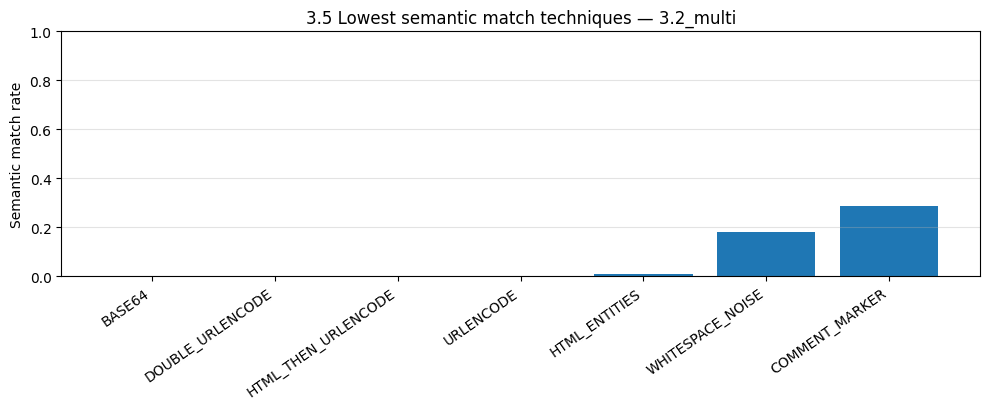

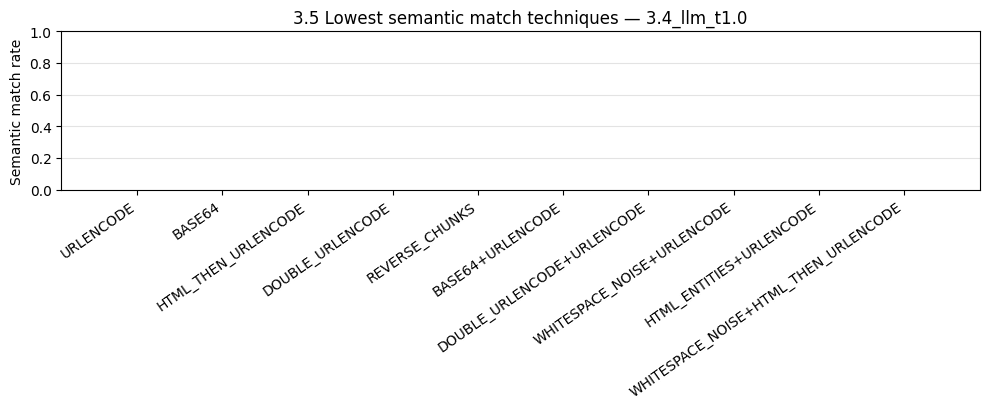

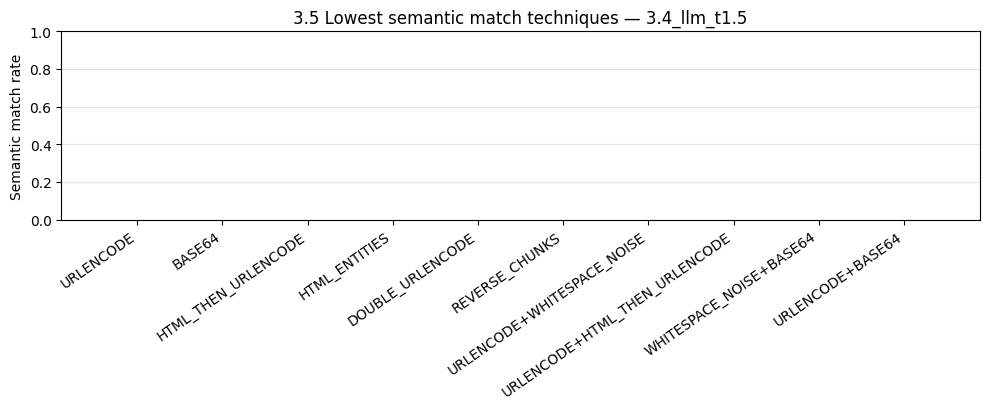

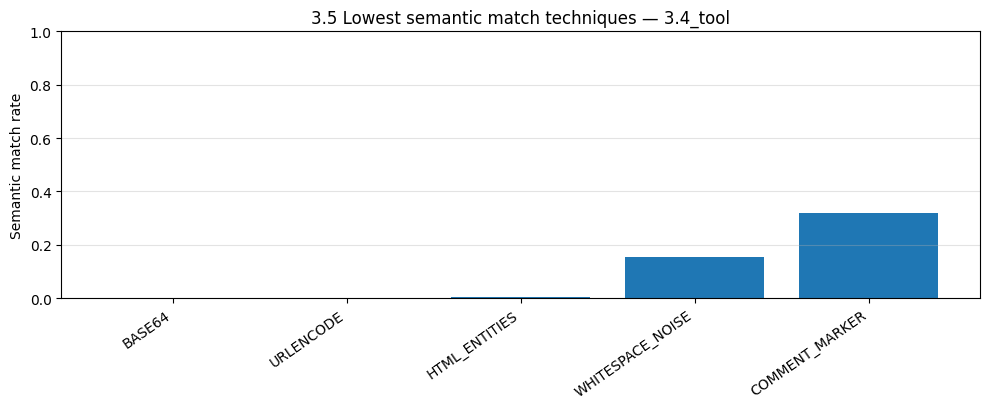

In [14]:
# ----------------------------
# 8) Plots
# ----------------------------
def plot_low_match(df_sum, source_name, top_k=10, out_name=None):
    sub = df_sum[df_sum["source"]==source_name].sort_values("semantic_match").head(top_k)
    x = np.arange(len(sub))
    fig, ax = plt.subplots(figsize=(10,4.2))
    ax.bar(x, sub["semantic_match"].to_numpy())
    ax.set_xticks(x)
    ax.set_xticklabels([t.upper() for t in sub["technique"]], rotation=35, ha="right")
    ax.set_ylabel("Semantic match rate")
    ax.set_title(f"3.5 Lowest semantic match techniques — {source_name}")
    ax.set_ylim(0.0, 1.0)
    ax.grid(axis="y", alpha=0.35)
    fig.tight_layout()
    if out_name:
        fig.savefig(out_name, dpi=200, bbox_inches="tight")
    plt.show()

for src in sorted(summary["source"].unique().tolist()):
    plot_low_match(summary, src, top_k=10, out_name=f"3_5_low_match_{src}.png")


In [15]:
# ----------------------------
# 9) Save artifacts
# ----------------------------
df_res.to_csv("3_5_semantic_equivalence_results.csv", index=False)
summary.to_csv("3_5_semantic_equivalence_summary.csv", index=False)
worst.to_csv("3_5_semantic_equivalence_worst_per_source.csv", index=False)

print("Saved CSVs:",
      "3_5_semantic_equivalence_results.csv,",
      "3_5_semantic_equivalence_summary.csv,",
      "3_5_semantic_equivalence_worst_per_source.csv")


Saved CSVs: 3_5_semantic_equivalence_results.csv, 3_5_semantic_equivalence_summary.csv, 3_5_semantic_equivalence_worst_per_source.csv
